In [2]:
import os
import pandas as pd
import geopandas as gpd
import fiona
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import rasterio  
from rasterio.plot import show
from matplotlib.lines import Line2D
import xarray as xr
from pyproj import Transformer
from scipy.interpolate import griddata
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import dask.dataframe as dd
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import pyvista as pv
from sklearn.decomposition import DictionaryLearning
from itertools import product
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.sparse import csr_matrix, vstack, eye, hstack
from scipy.sparse.linalg import lsmr
from joblib import Parallel, delayed
from tqdm import tqdm
import plotly.express as px
from scipy.spatial import cKDTree
# SimPEG functionality
from simpeg.potential_fields import magnetics
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (maps, data, data_misfit, inverse_problem, regularization, optimization, directives, inversion,)
# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz
# Common Python functionality
import matplotlib as mpl
import tarfile
mpl.rcParams.update({"font.size": 14})
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from simpeg.utils import plot2Ddata, model_builder
from simpeg.potential_fields import gravity, magnetics
from simpeg import (maps, data, data_misfit, inverse_problem, regularization, optimization, directives, inversion, utils,)
import tensorflow as tf
from tensorflow import keras
from keras.layers import (Input, Conv2D, Conv3D,MaxPooling2D, MaxPooling3D, UpSampling3D, BatchNormalization, Activation, Reshape, 
                        Concatenate, LeakyReLU, concatenate)
from keras.models import Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

2025-05-10 20:35:34.302171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
prefix="/scr/Mineral/AIKosh/"

In [4]:
density_X_dir = prefix+"ground_gravity_data_of_karnataka_and_andhra_pradesh_v1/Ground_gravity_asci_grid_geotiff/Physical_properties_rock_samples_Copy.csv"
ngpm_grav_dir = prefix+"/ground_gravity_data_of_karnataka_and_andhra_pradesh_v1/Ground_gravity_asci_grid_geotiff/ASCII/combined_NGPM_gravity_FINAL.csv"
bouguer_anomaly_dir = prefix+"/ground_gravity_data_of_karnataka_and_andhra_pradesh_v1/Ground_gravity_asci_grid_geotiff/GEOTIFF/NGPM_BA.tiff"
gdb_dir =prefix+"/aerogeophysical_spectrometric_data_of_karnataka_and_andhra_pradesh_v1/SPECTROMETRIC/DATABASE/GDB/spec.gdb"
tail_tmi_ge = prefix+"MAGNETIC/GEOTIFF/TAIL_TMI_GE.tiff"
xyz_dir = prefix+"/MAGNETIC/mag.XYZ"
tmi_cleaned_dir = prefix+"/MAGNETIC/TMI_Cleaned.txt"

## Setting Up Magnetic Data
NOTE: CODES ALREADY RUN! SKIP THIS STEP and IMPORT tmi_cleaned

### (1) Reading XYZ file

In [7]:
columns = [
    'BLOCK', 'AID', 'LINE', 'FIDUCIAL', 'DATE', 'GPSTIME', 'AZIMUTH',
    'LONGITUDE', 'LATITUDE', 'ALTIMETER', 'GPS_HEIGHT_GEOID', 'DTM',
    'PRESSURE', 'TEMPERATURE',
    'LEFT_TMI_RAW', 'RIGHT_TMI_RAW', 'TAIL_TMI_RAW',
    'LEFT_TMI_COMP', 'RIGHT_TMI_COMP', 'TAIL_TMI_COMP',
    'DIURNAL_1', 'DIURNAL_2', 'IGRF', 'INCLINATION', 'DECLINATION',
    'HGLONG', 'HGLAT', 'TMI_IGRF_TAIL', 'TAIL_TMI_LEV', 'TMI_FINAL_MLEV',
    'EXTRA_COLUMN'  # Placeholder for the unexpected 31st column
]

In [8]:
df_dask = dd.read_csv(
    xyz_dir,
    sep=r'\s+',
    header=None,
    names=columns,
    dtype='object',
    assume_missing=True
)

In [9]:
cols_needed = ['LATITUDE', 'LONGITUDE', 'DTM', 'ALTIMETER', 'TMI_FINAL_MLEV']

for col in cols_needed:
    df_dask[col] = dd.to_numeric(df_dask[col], errors='coerce')

df_cleaned = df_dask[cols_needed].dropna()

# Sample
df_sample = df_cleaned.sample(frac=0.01).compute()
df_sample.head()


,LATITUDE,LONGITUDE,DTM,ALTIMETER,TMI_FINAL_MLEV
127592,15.74902,76.2225,636.8,80.6,-186.5474
23482,15.74785,76.09395,664.9,88.61,-70.5017
43520,15.67265,76.05121,650.7,223.07,76.6861
126575,15.7009,76.17223,667.5,79.06,-272.3322
135756,15.69858,76.1778,669.0,76.76,-194.7673


In [ ]:
df_sample = df_sample.reset_index(drop=True)

In [ ]:
df_sample

In [12]:
df_sample.to_csv(tmi_cleaned_dir, index=False)

### (2) Converting to UTM

In [63]:
tmi_cleaned_dir = "/scr/Mineral/AIKosh/MAGNETIC/TMI_Cleaned.txt"

In [170]:
df_sample = pd.read_csv(tmi_cleaned_dir,sep=' ')
df_sample

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,630967.7509,1741552.9668,636.8000,80.6000,-186.5474
0,617195.1997,1.741348e+06,664.9,88.61,-70.5017
1,612657.3338,1.733005e+06,650.7,223.07,76.6861
2,625611.1351,1.736199e+06,667.5,79.06,-272.3322
3,626209.4924,1.735945e+06,669.0,76.76,-194.7673
4,610331.2147,1.737031e+06,657.4,82.86,43.4502
...,...,...,...,...,...
193343,676199.2358,1.543972e+06,605.7,84.30,-23.8339
193344,615284.2657,1.609114e+06,656.7,76.67,-74.0305
193345,691822.9596,1.553803e+06,589.4,85.55,7.3834
193346,715620.1487,1.530005e+06,666.7,84.36,-36.2711


transformer = Transformer.from_crs("EPSG:4326", "EPSG:32643", always_xy=True)
utm_x, utm_y = transformer.transform(df_sample["LONGITUDE"].values, df_sample["LATITUDE"].values)

df_sample["LONGITUDE"].values

df_sample['X'] = utm_x
df_sample['Y'] = utm_y

In [65]:
df_sample

,X,Y,DTM,ALTIMETER,TMI_FINAL_MLEV
0,630967.7509,1.741553e+06,636.8,80.60,-186.5474
1,617195.1997,1.741348e+06,664.9,88.61,-70.5017
2,612657.3338,1.733005e+06,650.7,223.07,76.6861
3,625611.1351,1.736199e+06,667.5,79.06,-272.3322
4,626209.4924,1.735945e+06,669.0,76.76,-194.7673
...,...,...,...,...,...
193344,676199.2358,1.543972e+06,605.7,84.30,-23.8339
193345,615284.2657,1.609114e+06,656.7,76.67,-74.0305
193346,691822.9596,1.553803e+06,589.4,85.55,7.3834
193347,715620.1487,1.530005e+06,666.7,84.36,-36.2711


In [66]:
# Copy to avoid altering original
df_export = df_sample[["X", "Y", "DTM", "ALTIMETER", "TMI_FINAL_MLEV"]].copy()

# Rename for clarity (optional)
df_export.columns = ["X", "Y", "DTM", "ALTIMETER", "TMI_FINAL_MLEV"]

# Format each column
df_export["X"] = df_export["X"].map(lambda x: f"{x:.4f}")
df_export["Y"] = df_export["Y"].map(lambda x: f"{x:.4f}")
df_export["DTM"] = df_export["DTM"].map(lambda x: f"{x:.4f}")
df_export["ALTIMETER"] = df_export["ALTIMETER"].map(lambda x: f"{x:.4f}")
df_export["TMI_FINAL_MLEV"] = df_export["TMI_FINAL_MLEV"].map(lambda x: f"{x:.4f}")

# Save without header or index
df_export.to_csv(tmi_cleaned_dir, sep=' ', index=False, header=False)

In [67]:
df_export

,X,Y,DTM,ALTIMETER,TMI_FINAL_MLEV
0,630967.7509,1741552.9668,636.8000,80.6000,-186.5474
1,617195.1997,1741347.9493,664.9000,88.6100,-70.5017
2,612657.3338,1733005.4954,650.7000,223.0700,76.6861
3,625611.1351,1736198.8229,667.5000,79.0600,-272.3322
4,626209.4924,1735945.4712,669.0000,76.7600,-194.7673
...,...,...,...,...,...
193344,676199.2358,1543971.8638,605.7000,84.3000,-23.8339
193345,615284.2657,1609114.1649,656.7000,76.6700,-74.0305
193346,691822.9596,1553803.3295,589.4000,85.5500,7.3834
193347,715620.1487,1530005.3970,666.7000,84.3600,-36.2711


In [68]:
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

In [69]:
tree = cKDTree(df_sample[["X", "Y"]].values)
mask = np.ones(len(df_sample), dtype=bool)

## (2a) Converting to Rectangular Grid  (Use them for DL)

In [70]:
x = df_sample['X'].map(float)
y = df_sample['Y'].map(float)

In [71]:
points = np.stack([x, y], axis=-1)

In [72]:
tree = cKDTree(points)

In [73]:
# Define regular grid over the domain (min-max range of your data)
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

In [80]:
# Generate grid points with specified spacing

#dh = 2400
#dy = 2850

x_grid = np.arange(x_min, x_max, 830)
y_grid = np.arange(y_min, y_max, 400)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

In [81]:
_, indices = tree.query(grid_points)

In [82]:
grid_points, grid_points.shape

(array([[ 607245.9936, 1520387.1427],
        [ 609645.9936, 1520387.1427],
        [ 612045.9936, 1520387.1427],
        ...,
        [ 789645.9936, 1742687.1427],
        [ 792045.9936, 1742687.1427],
        [ 794445.9936, 1742687.1427]]),
 (6241, 2))

In [33]:
df_selected = df_sample.iloc[indices].drop_duplicates()

## (3a) Exporting .txt & .obs file for full area inversion

In [110]:
df_selected[["X", "Y", "DTM"]].to_csv(prefix + "MAGNETIC/Magnetic/Complete_Dataset/magnetics_topo_coarse.txt", index=False, header=False, sep=' ')

In [10]:
df_selected = df_selected.copy()
df_selected["DTM"] = pd.to_numeric(df_selected["DTM"], errors="coerce")
df_selected["ALTIMETER"] = pd.to_numeric(df_selected["ALTIMETER"], errors="coerce")
df_selected["TOTAL_DTM"] = df_selected["DTM"] + df_selected["ALTIMETER"]

NameError: name 'df_selected' is not defined

In [112]:
df_selected[["X", "Y", "TOTAL_DTM", "TMI_FINAL_MLEV"]].to_csv(prefix + "MAGNETIC/Magnetic/Complete_Dataset/magnetics_data_coarse.obs", index=False, header=False, sep=' ')

### (4a) For gravity data (into coarse mode)

In [113]:
df_bouguer = pd.read_csv(ngpm_grav_dir)
df_bouguer.head()

,X,Y,bouguer_an,elevation,observed_g,theoretical_g,gravity_anomaly,toposheet
0,76.8616,14.2522,-72,548,978164,978345,-181,57B/15
1,76.9966,14.2552,-68,576,978164,978345,-181,57B/15
2,76.9861,14.2556,-67,573,978165,978345,-180,57B/15
3,76.8458,14.2535,-72,541,978165,978345,-180,57B/15
4,76.9423,14.2554,-68,558,978167,978345,-178,57B/15


In [61]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32643", always_xy=True)
utm_x, utm_y = transformer.transform(df_bouguer["X"].values, df_bouguer["Y"].values)

NameError: name 'df_bouguer' is not defined

In [9]:
df_bouguer['UTM_X'] = utm_x
df_bouguer['UTM_Y'] = utm_y
df_coords = df_bouguer.copy()

NameError: name 'utm_x' is not defined

In [6]:
gravity_coords = df_coords[['UTM_X', 'UTM_Y', 'bouguer_an']].to_numpy()

NameError: name 'df_coords' is not defined

In [5]:
mag_xyz = np.loadtxt(str(prefix + "MAGNETIC/Magnetic/Complete_Dataset/magnetics_topo_coarse.txt"))

In [6]:
mag_xyz.shape, gravity_coords.shape

NameError: name 'gravity_coords' is not defined

In [7]:
interp_points = mag_xyz[:, :2]

In [8]:
# interpolation values (gravity data)
gravity_points = gravity_coords[:, :2]
gravity_values = gravity_coords[:, 2]

NameError: name 'gravity_coords' is not defined

In [121]:
# Interpolate
bouguer_interp = griddata(
    points=gravity_points,
    values=gravity_values,
    xi=interp_points,
    method='linear'  # options: 'linear', 'nearest', 'cubic'
)

In [122]:
# Handle NaNs
nan_mask = np.isnan(bouguer_interp)

In [123]:
nan_mask = np.isnan(bouguer_interp)
if np.any(nan_mask):
    bouguer_interp[nan_mask] = griddata(
        points=gravity_points,
        values=gravity_values,
        xi=interp_points[nan_mask],
        method='nearest'
    )

In [124]:
gravity_array = np.column_stack((mag_xyz[:,0], mag_xyz[:,1], mag_xyz[:,2], bouguer_interp))
df_gravity = pd.DataFrame()
df_gravity['X'] = mag_xyz[:,0]
df_gravity['Y'] = mag_xyz[:,1]
df_gravity['Z'] = mag_xyz[:,2]
df_gravity['Bouguer_Interp'] = bouguer_interp

In [125]:
# Save to CSV
df_gravity.to_csv(prefix + '/GRAVITY/Gravity/bouguer_interpolated_coarse.csv', index=False, header=False, sep=' ', float_format="%.4f")

In [318]:
df_gravity[["X", "Y", "Z"]].to_csv(prefix + "GRAVITY/Gravity/Complete_Dataset/gravity_topo_coarse.txt", 
                                      index=False, header=False, sep=' ', float_format="%.4f")

In [319]:
df_gravity[["X", "Y", "Z", "Bouguer_Interp"]].to_csv(prefix + "GRAVITY/Gravity/Complete_Dataset/gravity_data_coarse.obs", index=False, header=False, sep=' ')


In [320]:
print(df_gravity["Bouguer_Interp"].max())
print(df_gravity["Bouguer_Interp"].min())

-44.1154054735103
-108.98714836139413


In [11]:
output_dir = prefix+"OUTPUT/GM_DATA/Localized_Area/"
dobs_grav_dir = prefix + "GRAVITY/Gravity/Complete_Dataset/gravity_data_coarse.obs"
dobs_mag_dir = prefix + "MAGNETIC/Magnetic/Complete_Dataset/magnetics_data_coarse.obs"
grav_topo_filename = prefix + "GRAVITY/Gravity/Complete_Dataset/gravity_topo_coarse.txt"
mag_topo_filename = prefix + "MAGNETIC/Magnetic/Complete_Dataset/magnetics_topo_coarse.txt"

In [12]:
dobs_grav = np.loadtxt(dobs_grav_dir)
dobs_mag = np.loadtxt(dobs_mag_dir)
xyz_topo = np.loadtxt(grav_topo_filename)

In [13]:
len(dobs_grav), xyz_topo.shape

(97567, (97567, 3))

In [14]:
receiver_locations = dobs_grav[:, 0:3]
dobs_grav = dobs_grav[:, -1]
dobs_mag = dobs_mag[:, -1]

In [15]:
print(dobs_grav.min())
print(dobs_grav.max())
print(dobs_mag.min())
print(dobs_mag.max())

-108.98714836139413
-44.1154054735103
-5918.6513
8413.2093


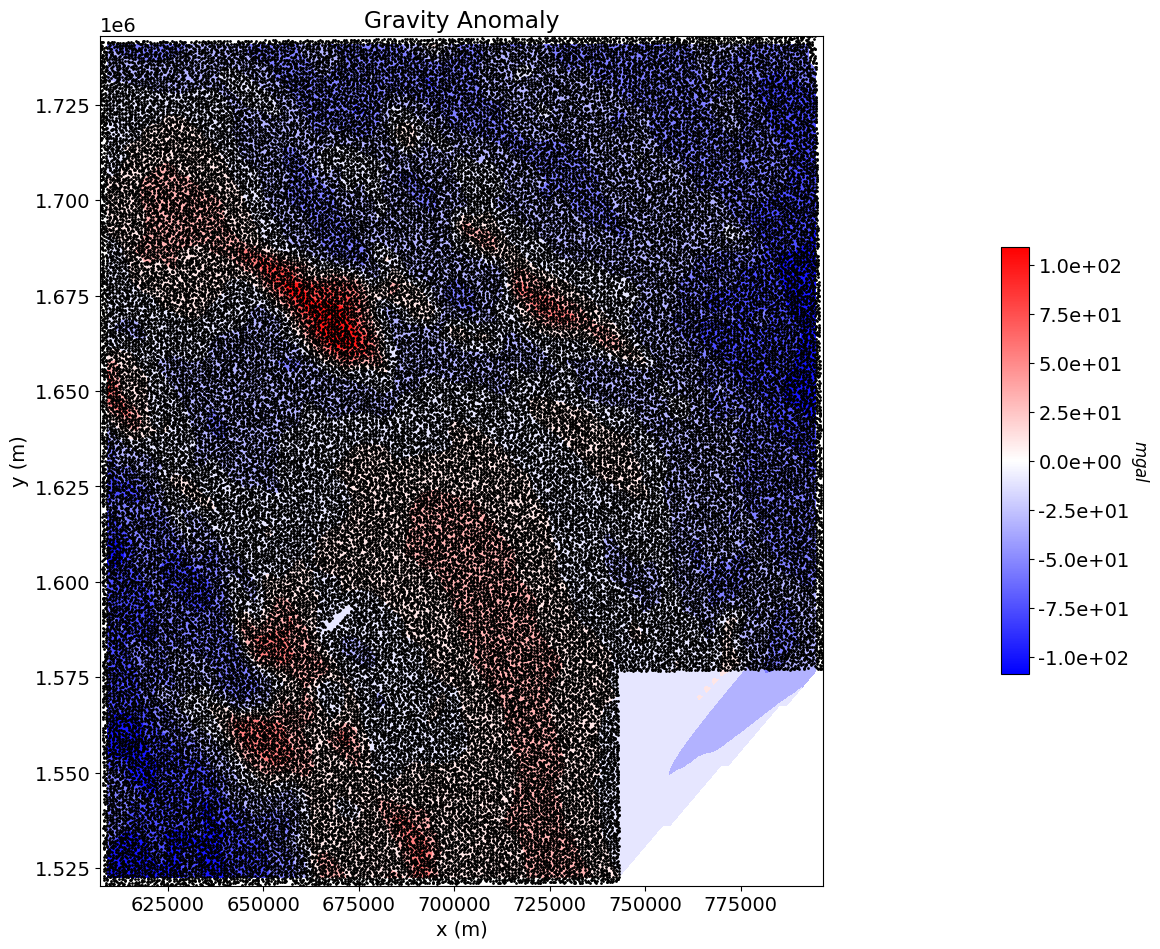

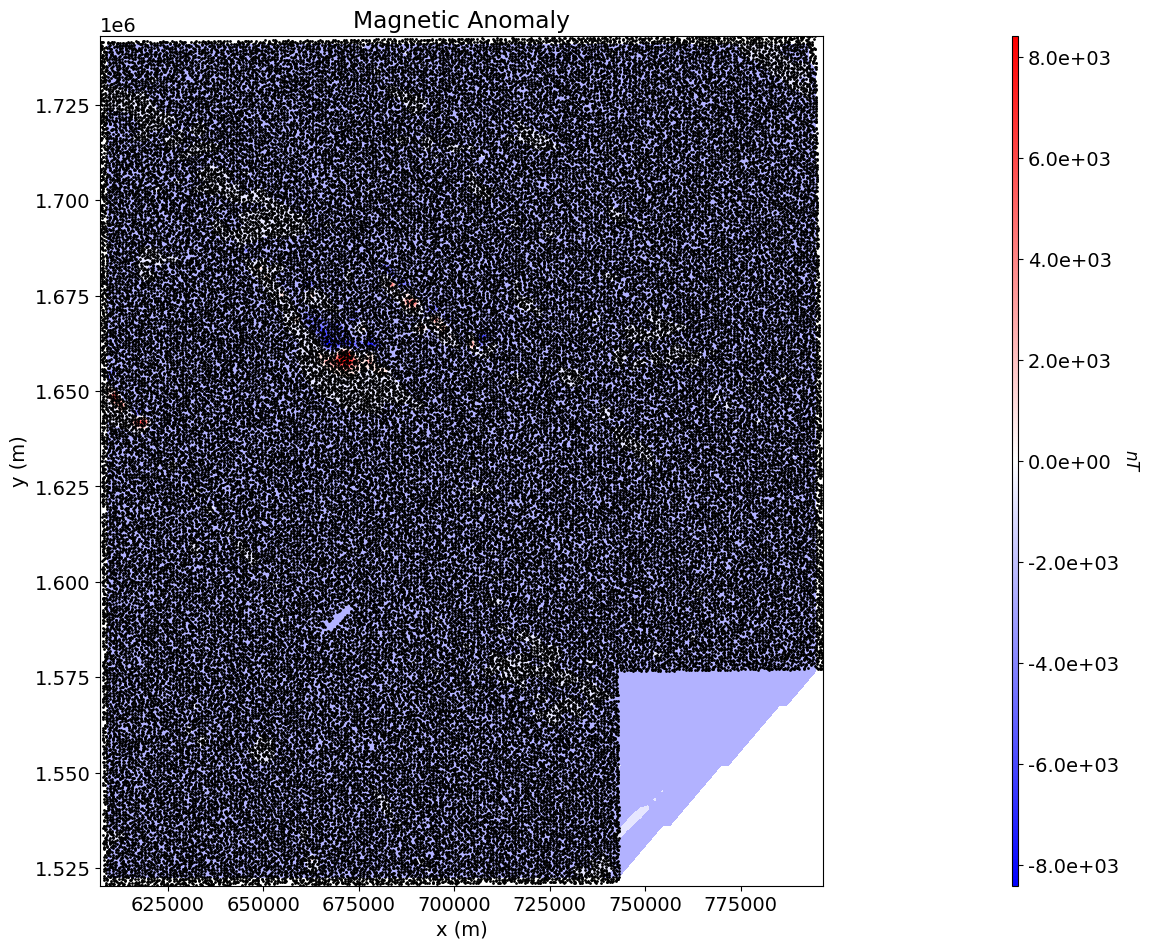

In [16]:
fig = plt.figure(figsize=(14, 10))

ax1 = fig.add_axes([0.1, 0.1, 0.63, 0.85])
plot2Ddata(receiver_locations, dobs_grav, ax=ax1, dataloc=True, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.02, 0.85])
norm = mpl.colors.Normalize(
    vmin=-np.max(np.abs(dobs_grav)), vmax=np.max(np.abs(dobs_grav))
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e" 
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)
ax2.set_aspect(0.07)
# magnetic data
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_axes([0.1, 0.1, 0.63, 0.85])
plot2Ddata(receiver_locations, dobs_mag, ax=ax1, dataloc=True, contourOpts={"cmap": "bwr"})
ax1.set_title("Magnetic Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.02, 0.85])
norm = mpl.colors.Normalize(
    vmin=-np.max(np.abs(dobs_mag)), vmax=np.max(np.abs(dobs_mag))
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)
ax2.set_aspect(0.008)

plt.show()

In [17]:
xmin, xmax = xyz_topo[:,0].min(), xyz_topo[:,0].max()
ymin, ymax = xyz_topo[:,1].min(), xyz_topo[:,1].max()
zmin, zmax = xyz_topo[:,2].min(), xyz_topo[:,2].max()
print(xmin, xmax)
print(ymin, ymax)
print(zmin, zmax)

607245.9936 796641.0571
1520387.1427 1743107.3007
270.3 1001.8


In [18]:
dh = 2400
dy = 2850
dz = 55
npad = 1
hx = [ (dh, 80)]
hy = [ (dy, 80)]
hz = [ (dz, 40)]

In [19]:
xyz_topo.shape, receiver_locations.shape

((97567, 3), (97567, 3))

In [20]:
origin_x = receiver_locations[:,0].min() - npad * dh
origin_y = receiver_locations[:,1].min() - npad * dy
origin_z = -1000                                    

In [21]:
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")
print(tensor_mesh.shape_cells[0])
print(tensor_mesh.shape_cells[1])
print(tensor_mesh.shape_cells[2])

80
80
40


In [22]:
tensor_mesh.origin = np.r_[origin_x, origin_y, origin_z]

In [23]:
tensor_mesh.cell_centers_x


array([606045.9936, 608445.9936, 610845.9936, 613245.9936, 615645.9936,
       618045.9936, 620445.9936, 622845.9936, 625245.9936, 627645.9936,
       630045.9936, 632445.9936, 634845.9936, 637245.9936, 639645.9936,
       642045.9936, 644445.9936, 646845.9936, 649245.9936, 651645.9936,
       654045.9936, 656445.9936, 658845.9936, 661245.9936, 663645.9936,
       666045.9936, 668445.9936, 670845.9936, 673245.9936, 675645.9936,
       678045.9936, 680445.9936, 682845.9936, 685245.9936, 687645.9936,
       690045.9936, 692445.9936, 694845.9936, 697245.9936, 699645.9936,
       702045.9936, 704445.9936, 706845.9936, 709245.9936, 711645.9936,
       714045.9936, 716445.9936, 718845.9936, 721245.9936, 723645.9936,
       726045.9936, 728445.9936, 730845.9936, 733245.9936, 735645.9936,
       738045.9936, 740445.9936, 742845.9936, 745245.9936, 747645.9936,
       750045.9936, 752445.9936, 754845.9936, 757245.9936, 759645.9936,
       762045.9936, 764445.9936, 766845.9936, 769245.9936, 77164

In [24]:
tensor_mesh

TensorMesh: 256,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     80    604,845.99    796,845.99  2,400.00  2,400.00    1.00
   y     80  1,517,537.14  1,745,537.14  2,850.00  2,850.00    1.00
   z     40     -1,000.00      1,200.00     55.00     55.00    1.00

In [25]:
print("# of cells: {}".format(tensor_mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(tensor_mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(tensor_mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(tensor_mesh.cell_volumes.max()))  # Largest cell size
print(tensor_mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 256000
# of x-faces: 259200
Origin: [ 6.04845994e+05  1.51753714e+06 -1.00000000e+03]
Max cell volume: 376200000.0
[[ 6.06045994e+05  1.51896214e+06 -9.72500000e+02]
 [ 6.08445994e+05  1.51896214e+06 -9.72500000e+02]
 [ 6.10845994e+05  1.51896214e+06 -9.72500000e+02]
 [ 6.13245994e+05  1.51896214e+06 -9.72500000e+02]
 [ 6.15645994e+05  1.51896214e+06 -9.72500000e+02]]


In [26]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(tensor_mesh, xyz_topo)

In [27]:
active_cells.shape

(256000,)

In [28]:
# Define mapping from model to active cells. The model consists of a density
# contrast value for each cell below the Earth's surface.
n_active = int(active_cells.sum())
model_map = maps.IdentityMap(nP=n_active)
print(n_active)

179877


In [29]:
active_inds = np.where(active_cells)[0]

In [30]:
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_cells, np.nan)
type(tensor_plotting_map), type(n_active)

(simpeg.maps._injection.InjectActiveCells, int)

### Generating Synthetic Density Model

In [31]:
n_models = 55000

In [31]:
output_dir = "synthetic_density_models"
os.makedirs(output_dir, exist_ok=True)

# Get active cell indices
active_inds = np.where(active_cells)[0]
cell_centers = tensor_mesh.gridCC[active_cells]
print(active_inds)
# Helper: Generate one model with 25 random block anomalies
def generate_density_block_model(i, n_blocks, background=0.01):
    model = np.ones(n_active) * background
    for _ in range(n_blocks):
        # Pick random block center from active cell centers
        cx, cy, cz = cell_centers[np.random.randint(0, n_active)]

        # Define block size (in meters)
        dx = np.random.uniform(24000, 48000)  # block size in x
        dy = np.random.uniform(28000, 57000)
        dz = np.random.uniform(55, 1000)

        # Identify cells within this block
        mask = (
            (np.abs(cell_centers[:, 0] - cx) <= dx / 2) &
            (np.abs(cell_centers[:, 1] - cy) <= dy / 2) &
            (np.abs(cell_centers[:, 2] - cz) <= dz / 2)
        )

        # Assign random Density (e.g., 0.2–1.0 g/cc) to those cells
        model[mask]  = np.random.uniform(0.1, 3)
        np.save(f"{output_dir}/density_{i:05d}.npy", model.astype(np.float32))
    return i

# ####CHAAANGGE HERE 22962
for i in range(n_models):
    model = generate_density_block_model(i,n_blocks=250)
#     np.save(f"{output_dir}/density_{i:05d}.npy", model.astype(np.float32))

# n_jobs = 22         
# # Parallel loop with progress bar
# results = Parallel(n_jobs=n_jobs)(
#     delayed(generate_density_block_model)(i, n_blocks=250) for i in range( 9162, n_models)
# )

[     0      1      2 ... 221625 225379 227947]


### Generating Synthetic Susceptibility Model

In [ ]:
output_dir = "synthetic_susceptibility_models"
os.makedirs(output_dir, exist_ok=True)

# Get active cell indices
active_inds = np.where(active_cells)[0]
cell_centers = tensor_mesh.gridCC[active_cells]

# Helper: Generate one model with 25 random block anomalies
def generate_mag_block_model(i,n_blocks, background=0.01):
    model = np.ones(n_active) * background
    for _ in range(n_blocks):
        # Pick random block center from active cell centers
        cx, cy, cz = cell_centers[np.random.randint(0, n_active)]

        # Define block size (in meters)
        dx = np.random.uniform(24000, 48000)  # block size in x
        dy = np.random.uniform(28000, 57000)
        dz = np.random.uniform(55, 1000)

        # Identify cells within this block
        mask = (
            (np.abs(cell_centers[:, 0] - cx) <= dx / 2) &
            (np.abs(cell_centers[:, 1] - cy) <= dy / 2) &
            (np.abs(cell_centers[:, 2] - cz) <= dz / 2)
        )

        # Assign random susceptibility to those cells
        np.save(f"{output_dir}/susceptibility_{i:05d}.npy", model.astype(np.float32))
        model[mask]  = np.random.uniform(-1, 1)
    return i

# # Generate and save 10,000 models
for i in range(n_models):
    model = generate_mag_block_model(i,in_blocks=200)
#     np.save(f"{output_dir}/susceptibility_{i:05d}.npy", model.astype(np.float32))
# n_jobs = 22         
# # Parallel loop with progress bar
# results = Parallel(n_jobs=n_jobs)(
#     delayed(generate_mag_block_model)(i, n_blocks=200) for i in range(n_models)
# )

### DEFINE THE SURVEY

In [32]:
receivers = []
for i in range(len(tensor_mesh.cell_centers_x)):
    for j in range(len(tensor_mesh.cell_centers_y)):
        receivers.append([tensor_mesh.cell_centers_x[i], tensor_mesh.cell_centers_y[j]])

receivers = np.array(receivers)
receivers.shape

(6400, 2)

In [33]:
points = receiver_locations[:, :2]         
values = receiver_locations[:, 2]

In [34]:
x_vals = receivers[:,0]
y_vals = receivers[:,1]
points, values.shape

(array([[ 608658.0057, 1520680.4393],
        [ 609761.5141, 1520522.4682],
        [ 610488.9822, 1520824.1914],
        ...,
        [ 792432.2245, 1743072.72  ],
        [ 793176.9996, 1742952.8036],
        [ 793732.681 , 1743107.3007]]),
 (97567,))

In [35]:
zz = griddata(points, np.array(values), (x_vals, y_vals), method='nearest') 

In [36]:
df = pd.DataFrame()
df['X'] = receivers[:,0]
df['Y'] = receivers[:,1]
df['Z'] = zz
rec = df.to_numpy()

In [37]:
rec.shape

(6400, 3)

In [38]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(rec, components="gz")
receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [39]:
mag_components=["tmi"]
receiver_mag = magnetics.receivers.Point(rec, components=mag_components)

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 33.5  # inclination [deg]
declination = 0.3  # declination [deg]
strength = 43800   # amplitude [nT] 

# Define the source field and survey for gravity data
source_field_mag = magnetics.sources.UniformBackgroundField(
    receiver_list=[receiver_mag],
    amplitude=strength,
    declination=declination,
    inclination=inclination,
)
survey_mag = magnetics.survey.Survey(source_field_mag)

In [40]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    rhoMap=model_map,
    active_cells=active_cells,
    store_sensitivities="ram", 
    engine="choclo",
)

In [41]:
simulation_mag = magnetics.simulation.Simulation3DIntegral(
    survey=survey_mag,
    mesh=tensor_mesh,
    model_type="scalar",
    chiMap=model_map,
    active_cells=active_cells,
    engine="choclo",
)

### Forward Simulation Of all Synthetic Models

In [ ]:
folder_path = "synthetic_density_models"
# Read each file: density_00001.npy to density_00100.npy
for i in range(0, n_models):
    print(i)
    file_name = f"density_{i:05d}.npy"
    file_path = os.path.join(folder_path, file_name)
    #print(file_path)
    if os.path.exists(file_path):
        density_data = np.load(file_path)
        gz = simulation.dpred(density_data)
        np.save(f"{folder_path}/density_gravity_pred{i:05d}.npy", gz.astype(np.float32))
    else:
        print(f"File {i} Not Found")

In [ ]:
folder_path = "synthetic_susceptibility_models"
# Read each file: density_00001.npy to density_00100.npy
for i in range(0, n_models):
    file_name = f"susceptibility_{i:05d}.npy"
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        sus_data = np.load(file_path)
        tmi = simulation_mag.dpred(sus_data)
        np.save(f"{folder_path}/susceptibility_tmi_pred{i:05d}.npy", tmi.astype(np.float32))
    else:
        print(f"File {i} Not Found")

### Building CNN-U-Net Architechture

In [42]:
# Block B: 2D ➔ 3D expansion
class BlockB(nn.Module):
    def __init__(self):
        super(BlockB, self).__init__()
        self.conv2d_1 = nn.Conv2d(2, 40, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(40)
        self.conv2d_2 = nn.Conv2d(40, 40, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(40)
        self.conv2d_3 = nn.Conv2d(40, 40, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(40)

    def forward(self, x):  # x: [B, 2, 80, 80]
        x = F.relu(self.bn1(self.conv2d_1(x)))
        x = F.relu(self.bn2(self.conv2d_2(x)))
        x = F.relu(self.bn3(self.conv2d_3(x)))
        x = F.interpolate(x, size=(80,80), mode='bilinear', align_corners=False)  # [B, 40, 40, 40]
        x = x.view(x.size(0), 1, 40, 80, 80)  # [B, 1, D, H, W]
        return x

In [43]:
# Encoder Block (3D)
def conv3d_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.LeakyReLU(),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.LeakyReLU()
    )

In [44]:
# Decoder Block (3D with skip connection)
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False)
        self.conv = conv3d_block(in_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        # crop if needed to match skip dimensions
        if x.shape[2:] != skip.shape[2:]:
            min_d = min(x.shape[2], skip.shape[2])
            min_h = min(x.shape[3], skip.shape[3])
            min_w = min(x.shape[4], skip.shape[4])
            x = x[:, :, :min_d, :min_h, :min_w]
            skip = skip[:, :, :min_d, :min_h, :min_w]
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [45]:
# 🔹 U-Net 3D Core
class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()
        self.enc1 = conv3d_block(1, 40)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = conv3d_block(40, 80)
        self.pool2 = nn.MaxPool3d(2)

        self.enc3 = conv3d_block(80, 160)
        self.pool3 = nn.MaxPool3d(2)

        self.bottleneck = conv3d_block(160, 250)

        self.dec1 = DecoderBlock(250, 160, 160)
        self.dec2 = DecoderBlock(160, 80, 80)
        self.dec3 = DecoderBlock(80, 40, 40)

    def forward(self, x):
        s1 = self.enc1(x)
        p1 = self.pool1(s1)

        s2 = self.enc2(p1)
        p2 = self.pool2(s2)

        s3 = self.enc3(p2)
        p3 = self.pool3(s3)

        b = self.bottleneck(p3)

        d1 = self.dec1(b, s3)
        d2 = self.dec2(d1, s2)
        d3 = self.dec3(d2, s1)

        return d3

In [46]:
# Block D: Regression head
class BlockD(nn.Module):
    def __init__(self):
        super(BlockD, self).__init__()
        self.conv1 = nn.Conv3d(40, 30, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(30)
        self.conv2 = nn.Conv3d(30, 20, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(20)
        self.conv3 = nn.Conv3d(20, 10, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(10)
        self.output = nn.Conv3d(10, 2, kernel_size=1)  # Output: 2 channels

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.output(x)

In [47]:
## FOR INPUT SHAPE (80,80,2) OUTPUT: 179906

class GravityMagInversionNet(nn.Module):
    def __init__(self, active_indices):
        super(GravityMagInversionNet, self).__init__()
        self.block_b = BlockB()
        self.unet = UNet3D()
        self.block_d = BlockD()
        self.active_indices = active_indices  # torch.tensor([...])
    
    def forward(self, x):  # x: [B, 2, 80, 80]
        x = self.block_b(x)
        x = self.unet(x)
        x = self.block_d(x)  # [B, 2, 40, 40, 40]
        
        # Reshape to [B, D*H*W, 2]
        x = x.permute(0, 2, 3, 4, 1).reshape(x.size(0), -1, 2)
        
        # Select only active voxels
        x = x[:, self.active_indices, :]  # [B, 179906, 2]
        return x


### Do Not Run This

CNN_model = GravityMagInversionNet(active_inds)
CNN_model.train()

criterion_mse = nn.MSELoss()


optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-4)

folder_path_sus = "synthetic_susceptibility_models"
folder_path_density = "synthetic_density_models"
# Read each file: density_00001.npy to density_00100.npy
dataloader_size=10
running_loss=0.0
for i in range(1, dataloader_size+1):
    file_name_tmi = f"susceptibility_tmi_pred{i:05d}.npy"
    file_name_gravity = f"density_gravity_pred{i:05d}.npy"
    file_name_susceptibility = f"susceptibility_{i:05d}.npy"
    file_name_density = f"density_{i:05d}.npy"
    
    file_path_susceptibility = os.path.join(folder_path_sus, file_name_susceptibility)
    file_path_density = os.path.join(folder_path_density, file_name_density)
    file_path_tmi = os.path.join(folder_path_sus, file_name_tmi)
    file_path_gravity = os.path.join(folder_path_density, file_name_gravity)

    if os.path.exists(file_path_gravity):
        gravity_data = np.load(file_path_gravity)
        gravity_data = gravity_data.reshape((80, 80))
        density_data = np.load(file_path_density)
        #print(f"Shape of Density Data {density_data.shape}")
    if os.path.exists(file_path_tmi):
        magnetic_data = np.load(file_path_tmi)
        magnetic_data = magnetic_data.reshape((80, 80))
        susceptibility_data = np.load(file_path_susceptibility)
        #print(f"Shape of susceptibility Data {susceptibility_data.shape}")
    combined_gravity_tmi = np.stack([gravity_data, magnetic_data], axis=0)
   
    # Add batch dimension → shape: (1, 2, 80, 80)
    input_tensor = torch.tensor(combined_gravity_tmi, dtype=torch.float32).unsqueeze(0)   
    labeled_tensor = torch.stack(
            [torch.tensor(density_data, dtype=torch.float32),
            torch.tensor(susceptibility_data, dtype=torch.float32)],
            dim=1
    ).unsqueeze(0)
    input_tensor
    labeled_tensor
    if i==1:
       print(f"Input Tensor Shape {input_tensor.shape}")
       print(f"Labeled Tensor Shape {labeled_tensor.shape}")
    output = CNN_model(input_tensor)
    loss_mse = criterion_mse(output, labeled_tensor)
    

    loss_mse.backward()
    optimizer.step()
    running_loss += loss.item()
    
print(f"Average Running Loss Is {running_loss/dataloader_size}")   
    
    
    
#input_tensor = torch.randn(1, 2, 80, 80)  # Example: 1 sample with 2 channels
#print(input_tensor.shape)
print(combined_gravity_tmi.shape)
print(output.shape)
#output = CNN_model(input_tensor)  # Shape: (1, 2, 40, 40, 40)

print("Output shape:", output.shape)

CNN_model.cuda()

### Segregating The Dataset For Training & Validation

### Standardizing The Dataset

In [80]:
# Aggregate stats
all_grav_values = []
all_mag_values = []
density_dir= "synthetic_density_models"  # adjust if needed
sus_dir= "synthetic_susceptibility_models"
for idx in tqdm(range(n_models)):
    g_path = os.path.join(density_dir, f"density_gravity_pred{idx:05d}.npy")
    tmi_path = os.path.join(sus_dir, f"susceptibility_tmi_pred{idx:05d}.npy")

    grav = np.load(g_path)
    mag = np.load(tmi_path)

    all_grav_values.append(grav.flatten())
    all_mag_values.append(mag.flatten())

# Stack and compute global stats
all_grav = np.concatenate(all_grav_values)
all_mag = np.concatenate(all_mag_values)

grav_mean, grav_std = np.mean(all_grav), np.std(all_grav)
tmi_mean, tmi_std = np.mean(all_mag), np.std(all_mag)

print(f"Gravity: mean={grav_mean:.4f}, std={grav_std:.4f}")
print(f"TMI:     mean={tmi_mean:.4f}, std={tmi_std:.4f}")

100%|██████████████████████████████████████████████████████████████████████| 55000/55000 [00:17<00:00, 3066.15it/s]


Gravity: mean=-87.7377, std=29.7082
TMI:     mean=-20.2856, std=4458.4297


In [81]:
class GravityMagDataset(Dataset):
    def __init__(self, density_dir, sus_dir, pred_density_dir, pred_sus_dir, n_samples,grav_mean,grav_std,tmi_mean,tmi_std):
        self.density_dir = density_dir
        self.sus_dir = sus_dir
        self.pred_density_dir = pred_density_dir
        self.pred_sus_dir = pred_sus_dir
        self.n_samples = n_samples
    
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        #idx += 1  # filenames are 1-indexed
        #print(f"Loading sample index {idx}")  # ← Add this for debug
        # File paths
        g_path = os.path.join(self.pred_density_dir, f"density_gravity_pred{idx:05d}.npy")
        tmi_path = os.path.join(self.pred_sus_dir, f"susceptibility_tmi_pred{idx:05d}.npy")
        label_g_path = os.path.join(self.density_dir, f"density_{idx:05d}.npy")
        label_s_path = os.path.join(self.sus_dir, f"susceptibility_{idx:05d}.npy")
        
        # Load and reshape
        
        g = np.load(g_path).reshape(80, 80)
        tmi = np.load(tmi_path).reshape(80, 80)
        
        # Standardize to mean=0, std=1
        g = (g - grav_mean) / grav_std
        tmi = (tmi - tmi_mean) / tmi_std
        
        y_density = np.load(label_g_path)
        y_sus = np.load(label_s_path)

        # Stack input and label
        x = np.stack([g, tmi], axis=0)                      # (2, 80, 80)
        y = np.stack([y_density, y_sus], axis=1)            # (179906, 2)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

#summary(model, input_size=(1, 2, 80, 80))i have my cnn+unet+cnn implemented, but how to use labelled density and susceptibility model to find mse loss from predicted Output shape: torch.Size([1, 179906, 2])

In [83]:
full_dataset = GravityMagDataset(
    density_dir="synthetic_density_models",
    sus_dir="synthetic_susceptibility_models",
    pred_density_dir="synthetic_density_models",  # adjust if needed
    pred_sus_dir="synthetic_susceptibility_models",
    n_samples=n_models, # or 24000
    grav_mean=grav_mean,
    grav_std=grav_std,
    tmi_mean=tmi_mean,
    tmi_std=tmi_std
)

# Set random seed for reproducibility
torch.manual_seed(42)

# Define split sizes
total_samples = len(full_dataset)
train_size = int(0.8 * total_samples)  # 80% train
val_size = total_samples - train_size  # 20% validation
print(f"Total Samples: {total_samples}")
print(f"Train Size: {train_size}")
print(f"Validation Size: {val_size}")
# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

Total Samples: 55000
Train Size: 44000
Validation Size: 11000


### Training Model In Batches

In [84]:
%%time 
torch.cuda.empty_cache()
CNN_model = GravityMagInversionNet(active_inds)
criterion_mse = nn.MSELoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-4)

CNN_model.train()
running_loss = 0.0
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=2)
for batch_idx, (input_tensor, labeled_tensor) in enumerate(train_loader):
    input_tensor = input_tensor        # [B, 2, 80, 80]
    labeled_tensor = labeled_tensor    # [B, 179906, 2]
    #print(f"Input Tensor Shape {input_tensor.shape}")
    #print(f"Labeled Tensor Shape {labeled_tensor.shape}")
    optimizer.zero_grad()
    output = CNN_model(input_tensor)          # [B, 179906, 2]
    loss = criterion_mse(output, labeled_tensor)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if batch_idx%500==0:
        print(f"Processing Batch No. {running_loss/(batch_idx+1)}")

avg_loss = running_loss / len(train_loader)
print(f"✅ Average Running Loss: {avg_loss:.6f}")

Processing Batch No. 1.4917248487472534
Processing Batch No. 0.6415979319703793
Processing Batch No. 0.5721407108433121
Processing Batch No. 0.5385891120089125
✅ Average Running Loss: 0.527440
CPU times: user 13d 19h 10min 25s, sys: 4d 10h 45min 31s, total: 18d 5h 55min 57s
Wall time: 1d 5min 56s


In [85]:
torch.save(CNN_model, 'U_NET_55000_SAMPLES.pth')

In [86]:
len(train_loader)

1760

### Evaluation Of Model 

In [87]:
def evaluate_model(model):
    model.eval()  # switch to evaluation mode

    total_mse = 0.0
    total_mae = 0.0
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()
    val_loader = DataLoader(val_dataset, batch_size=25, shuffle=True, num_workers=2)
    with torch.no_grad():
        for batch_idx, (input_tensor, labeled_tensor) in enumerate(val_loader):
            input_tensor = input_tensor
            labeled_tensor = labeled_tensor

            output = model(input_tensor)  # shape: [B, 179906, 2]

            loss_mse = criterion_mse(output, labeled_tensor)
            loss_mae = criterion_mae(output, labeled_tensor)

            total_mse += loss_mse.item()
            total_mae += loss_mae.item()
            if batch_idx %100 ==0: 
                print(f"🔍 Eval Batch {batch_idx} ➤ MSE: {loss_mse.item():.6f}, MAE: {loss_mae.item():.6f}")

    avg_mse = total_mse / len(val_loader)
    avg_mae = total_mae / len(val_loader)

    print(f"\n Evaluation Summary ➤ Avg MSE: {avg_mse:.6f}, Avg MAE: {avg_mae:.6f}")
    return avg_mse, avg_mae

In [89]:
len(val_loader)

NameError: name 'val_loader' is not defined

In [88]:
 evaluate_model(CNN_model)

🔍 Eval Batch 0 ➤ MSE: 0.465493, MAE: 0.542536
🔍 Eval Batch 100 ➤ MSE: 0.456910, MAE: 0.538489
🔍 Eval Batch 200 ➤ MSE: 0.470168, MAE: 0.545985
🔍 Eval Batch 300 ➤ MSE: 0.458336, MAE: 0.539817
🔍 Eval Batch 400 ➤ MSE: 0.462177, MAE: 0.539964

 Evaluation Summary ➤ Avg MSE: 0.461026, Avg MAE: 0.540540


(0.4610257455571131, 0.5405402207916433)

### Load NPY 

In [56]:
gravity_val = np.load("/scr/Mineral/AIKosh/NOTEBOOKS/synthetic_density_models/density_gravity_pred00020.npy").reshape(80, 80)
density_val = np.load("/scr/Mineral/AIKosh/NOTEBOOKS/synthetic_density_models/density_00020.npy")
tmi_val = np.load("/scr/Mineral/AIKosh/NOTEBOOKS/synthetic_susceptibility_models/susceptibility_tmi_pred00020.npy").reshape(80, 80)
susceptibility_val = np.load("/scr/Mineral/AIKosh/NOTEBOOKS/synthetic_susceptibility_models/susceptibility_00020.npy")

In [57]:
# Stack input and label
x = np.stack([gravity_val, tmi_val], axis=0)                      # (2, 80, 80)
y = np.stack([density_val, susceptibility_val], axis=1)            # (179906, 2)

Computing Min and Max of density values
-----------------------------------------
0.0100, 2.9861


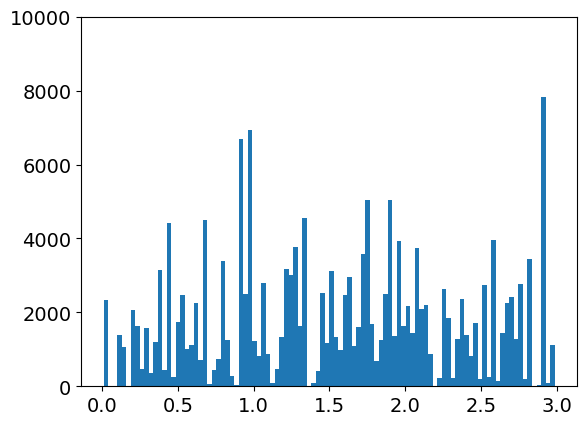

In [58]:
print("Computing Min and Max of density values")
print("-----------------------------------------")
print(f"{density_val.min():.4f}, {density_val.max():.4f}")
plt.hist(density_val, bins=100)
plt.ylim(0,10000)
plt.show()

In [59]:
input_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
output_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
print(input_tensor.shape)

torch.Size([1, 2, 80, 80])


In [57]:
print(type(input_tensor))

<class 'torch.Tensor'>


In [58]:
CNN_model.eval()
with torch.no_grad():
    pred_output = CNN_model(input_tensor)  # shape: (1, 179906, 2)

In [59]:
pred_output[:,0].min(), pred_output[:,0].max(), pred_output[:,1].min(), pred_output[:,1].max()

(tensor(-0.0249), tensor(0.3192), tensor(-0.0421), tensor(0.3069))

In [60]:
pred_output.shape, input_tensor.shape

(torch.Size([1, 179877, 2]), torch.Size([1, 2, 80, 80]))

In [124]:
df_TMI_Observed = pd.read_csv(prefix + 'NOTEBOOKS/top_layer_TMI.csv', sep=' ')
df_Bouger_Observed = pd.read_csv(prefix + 'NOTEBOOKS/top_layer_resbouguer.csv', sep=' ')

In [130]:
Np_Bouger_Observed=df_Bouger_Observed['Residual_Bouguer'].to_numpy().reshape(80,80)
Np_TMI_Observed=df_TMI_Observed['TMI_interp'].to_numpy().reshape(80,80)

In [132]:
x = np.stack([Np_Bouger_Observed, Np_TMI_Observed], axis=0)                      # (2, 80, 80)
input_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

In [133]:
CNN_model.eval()
with torch.no_grad():
    pred_output = CNN_model(input_tensor)  # shape: (1, 179906, 2)

In [134]:
pred_output

tensor([[[ 0.3205, -0.0263],
         [ 0.3056, -0.0416],
         [ 0.3006, -0.0258],
         ...,
         [ 0.3389,  0.0207],
         [ 0.3387, -0.0205],
         [ 0.3567,  0.0230]]])

In [66]:
test_density_val = np.load("/scr/Mineral/AIKosh/NOTEBOOKS/synthetic_density_models/density_00425.npy")

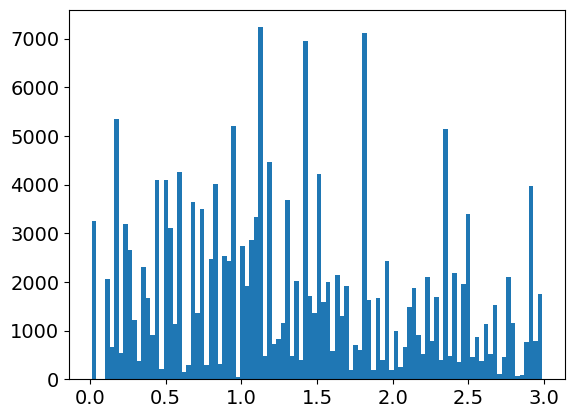

In [67]:
test_density_val
plt.hist(test_density_val, bins=100)
plt.show()

In [68]:
for yind in range(80):
    fig = plt.figure(figsize=(21, 9))
    ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
    
    norm = mpl.colors.Normalize(vmin=test_density_val.min(), vmax=test_density_val.max())
    tensor_mesh.plot_slice(
        tensor_plotting_map * test_density_val,
        normal="Y",
        ax=ax1,
        ind=yind,       #int(tensor_mesh.shape_cells[1] / 2),
        grid=True,
        pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
    )
    ax1.set_title(f"Starting Model (slice at y = {yind} m)")
    
    ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    cbar = mpl.colorbar.ColorbarBase(
        ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)
    plt.savefig("/scr/Mineral/AIKosh/OUTPUT/delete/" + f"Img_at_{yind}.png")
    plt.close()


In [129]:
df_TMI_Observed

,x,y,z,TMI_interp
0,606073.4936,1.518990e+06,760,-3.9854
1,606073.4936,1.521840e+06,760,-24.8757
2,606073.4936,1.524690e+06,760,-27.3265
3,606073.4936,1.527540e+06,760,169.9078
4,606073.4936,1.530390e+06,815,326.3636
...,...,...,...,...
6395,795673.4936,1.732740e+06,375,144.7698
6396,795673.4936,1.735590e+06,375,126.6879
6397,795673.4936,1.738440e+06,375,-0.7023
6398,795673.4936,1.741290e+06,375,41.5533


In [81]:
active_mask_3d = active_cells.reshape((80, 80, 40))  # shape: (nx, ny, nz)

In [82]:
print(active_mask_3d.shape)
active_indices = torch.where(torch.tensor(active_cells))[0]
print(active_indices.shape)

(80, 80, 40)
torch.Size([179921])


In [306]:
cnn_model = GravityMagInversionNet(active_indices)

In [308]:
cnn_model

GravityMagInversionNet(
  (block_b): BlockB(
    (conv2d_1): Conv2d(2, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d_2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d_3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (unet): UNet3D(
    (enc1): Sequential(
      (0): Conv3d(1, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

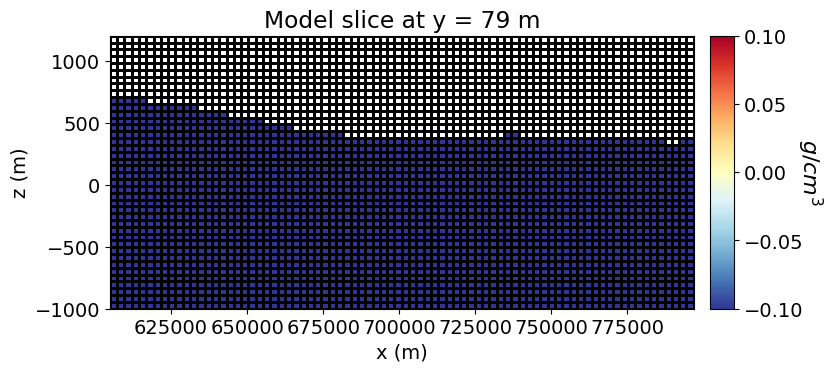

In [569]:
    
fig = plt.figure(figsize=(8, 3.5))
y_ind = 79
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
tensor_mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=y_ind,
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title(f"Model slice at y = {y_ind} m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

### Skip this step if not computing finer grid

#### (2) Converting to 180 x 180 grid interval

In [17]:
df_export

,X,Y,DTM,ALTIMETER,TMI_FINAL_MLEV
0,769490.1373,1586479.5858,506.7000,94.7300,-105.0478
1,711312.0502,1626306.0578,507.3000,82.9700,-24.3526
2,711905.4738,1691792.6105,419.3000,80.8000,-61.7591
3,632490.6742,1706163.8082,551.3000,81.0900,227.3200
4,701429.0688,1703403.9446,440.1000,129.6000,36.6666
...,...,...,...,...,...
193344,760017.0432,1657192.7035,416.1000,78.2500,101.3164
193345,707374.6304,1625338.1271,523.4000,75.6900,-75.0713
193346,764148.7523,1647327.7409,341.8000,83.3500,19.3006
193347,700233.7060,1560511.7078,577.2000,76.8200,39.1135


## Square Grids

In [18]:
# Greedy filtering — flag points that are within 180m of already accepted ones
for i in range(len(df_export)):
    if not mask[i]:
        continue
    neighbors = tree.query_ball_point(df_export.iloc[i][["X", "Y"]], r=180)
    neighbors.remove(i)  # exclude self
    mask[neighbors] = False  # remove all within 180 m

In [19]:
# Filtered points
filtered_df = df_export[mask]
print(f"Original points: {len(df_export)}, Filtered: {len(filtered_df)}")

Original points: 193349, Filtered: 149919


In [20]:
filtered_df.isnull().values.any()

False

In [21]:
filtered_df

,X,Y,DTM,ALTIMETER,TMI_FINAL_MLEV
0,769490.1373,1586479.5858,506.7000,94.7300,-105.0478
1,711312.0502,1626306.0578,507.3000,82.9700,-24.3526
2,711905.4738,1691792.6105,419.3000,80.8000,-61.7591
3,632490.6742,1706163.8082,551.3000,81.0900,227.3200
4,701429.0688,1703403.9446,440.1000,129.6000,36.6666
...,...,...,...,...,...
193342,756549.3433,1733900.9625,419.8000,86.4100,-10.4981
193345,707374.6304,1625338.1271,523.4000,75.6900,-75.0713
193346,764148.7523,1647327.7409,341.8000,83.3500,19.3006
193347,700233.7060,1560511.7078,577.2000,76.8200,39.1135


### (3) Exporting .txt & .obs file for full area inversion

In [22]:
filtered_df[["X", "Y", "DTM"]].to_csv(prefix + "MAGNETIC/Magnetic/Complete_Dataset/magnetics_topo_full.txt", index=False, header=False, sep=' ')

In [23]:
filtered_df = filtered_df.copy()
filtered_df["DTM"] = pd.to_numeric(filtered_df["DTM"], errors="coerce")
filtered_df["ALTIMETER"] = pd.to_numeric(filtered_df["ALTIMETER"], errors="coerce")
filtered_df["TOTAL_DTM"] = filtered_df["DTM"] + filtered_df["ALTIMETER"]

In [24]:
filtered_df[["X", "Y", "TOTAL_DTM", "TMI_FINAL_MLEV"]].to_csv(prefix + "MAGNETIC/Magnetic/Complete_Dataset/magnetics_data_full.obs", index=False, header=False, sep=' ')


## Setting Up Gravity Data

In [25]:
df_bouguer = pd.read_csv(ngpm_grav_dir)
df_bouguer.head()

,X,Y,bouguer_an,elevation,observed_g,theoretical_g,gravity_anomaly,toposheet
0,76.8616,14.2522,-72,548,978164,978345,-181,57B/15
1,76.9966,14.2552,-68,576,978164,978345,-181,57B/15
2,76.9861,14.2556,-67,573,978165,978345,-180,57B/15
3,76.8458,14.2535,-72,541,978165,978345,-180,57B/15
4,76.9423,14.2554,-68,558,978167,978345,-178,57B/15


### (1) Converting to UTM

In [26]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32643", always_xy=True)
utm_x, utm_y = transformer.transform(df_bouguer["X"].values, df_bouguer["Y"].values)

In [27]:
df_bouguer['UTM_X'] = utm_x
df_bouguer['UTM_Y'] = utm_y
df_coords = df_bouguer.copy()

In [28]:
gravity_coords = df_coords[['UTM_X', 'UTM_Y', 'bouguer_an']].to_numpy()

#### (1A) Loading Magnetic Data for Bouguer interpolation at 180 x 180 grid

In [29]:
mag_xyz = np.loadtxt(str(prefix + "MAGNETIC/Magnetic/Complete_Dataset/magnetics_topo_full.txt"))

In [30]:
mag_xyz.shape, gravity_coords.shape

((149919, 3), (22816, 3))

In [31]:
interp_points = mag_xyz[:, :2]

In [32]:
# interpolation values (gravity data)
gravity_points = gravity_coords[:, :2]
gravity_values = gravity_coords[:, 2]

In [33]:
# Interpolate
bouguer_interp = griddata(
    points=gravity_points,
    values=gravity_values,
    xi=interp_points,
    method='linear'  # options: 'linear', 'nearest', 'cubic'
)

In [34]:
# Handle NaNs
nan_mask = np.isnan(bouguer_interp)

In [35]:
nan_mask = np.isnan(bouguer_interp)
if np.any(nan_mask):
    bouguer_interp[nan_mask] = griddata(
        points=gravity_points,
        values=gravity_values,
        xi=interp_points[nan_mask],
        method='nearest'
    )

### (1B) Loading Bounguer Anomaly raster file for comparison

In [36]:
with rasterio.open(bouguer_anomaly_dir) as src:
    ba = src.read(1)
    print(src.transform)
    ba_transform = src.transform
    ba_meta = src.meta 
    ba_crs = src.crs

x = np.linspace(ba_transform[2], ba_transform[2] + ba_transform[0] * ba.shape[1], ba.shape[1])
y = np.linspace(ba_transform[5] + ba_transform[4] * ba.shape[0], ba_transform[5], ba.shape[0])
xx, yy = np.meshgrid(x, y)

ba = np.ma.masked_equal(ba, ba_meta['nodata'])

| 500.00, 0.00, 607250.00|
| 0.00,-500.00, 1743250.00|
| 0.00, 0.00, 1.00|


In [37]:
mag_xyz.shape

(149919, 3)

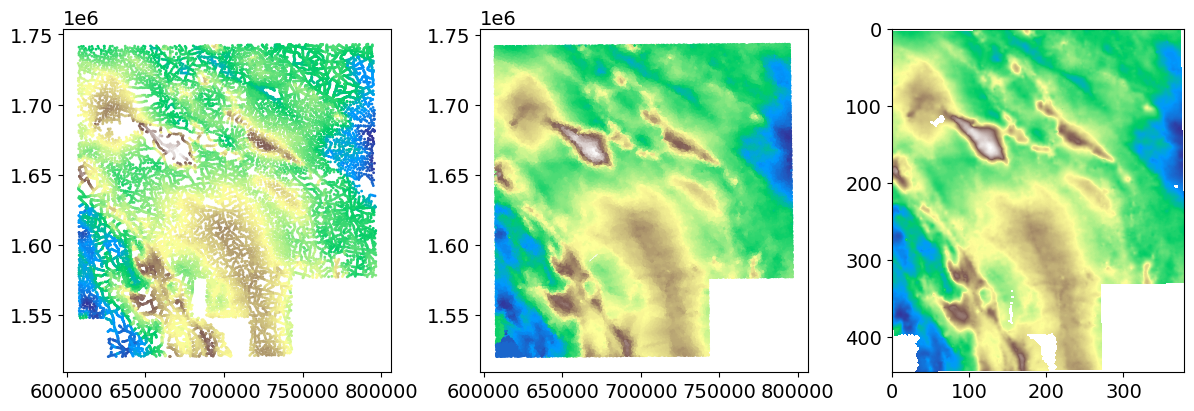

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

axs[0].scatter(gravity_coords[:,0], gravity_coords[:,1], c=gravity_coords[:,2], cmap='terrain', s=1, label='Gravity Data')
axs[1].scatter(mag_xyz[:,0], mag_xyz[:,1], c=bouguer_interp, cmap='terrain', s=1, label='Interpolated at Mag Points')
axs[2].imshow(ba, cmap='terrain')
plt.show()

In [39]:
gravity_array = np.column_stack((mag_xyz[:,0], mag_xyz[:,1], mag_xyz[:,2], bouguer_interp))
df_gravity = pd.DataFrame()
df_gravity['X'] = mag_xyz[:,0]
df_gravity['Y'] = mag_xyz[:,1]
df_gravity['Z'] = mag_xyz[:,2]
df_gravity['Bouguer_Interp'] = bouguer_interp

In [40]:
df_gravity

,X,Y,Z,Bouguer_Interp
0,769490.1373,1.586480e+06,506.7,-81.509151
1,711312.0502,1.626306e+06,507.3,-74.000000
2,711905.4738,1.691793e+06,419.3,-76.816488
3,632490.6742,1.706164e+06,551.3,-71.808462
4,701429.0688,1.703404e+06,440.1,-84.952569
...,...,...,...,...
149914,756549.3433,1.733901e+06,419.8,-92.027835
149915,707374.6304,1.625338e+06,523.4,-71.920054
149916,764148.7523,1.647328e+06,341.8,-87.438448
149917,700233.7060,1.560512e+06,577.2,-79.749778


In [41]:
mag_xyz

array([[7.69490137e+05, 1.58647959e+06, 5.06700000e+02],
       [7.11312050e+05, 1.62630606e+06, 5.07300000e+02],
       [7.11905474e+05, 1.69179261e+06, 4.19300000e+02],
       ...,
       [7.64148752e+05, 1.64732774e+06, 3.41800000e+02],
       [7.00233706e+05, 1.56051171e+06, 5.77200000e+02],
       [7.14055500e+05, 1.60997005e+06, 5.20900000e+02]])

### (3) Exporting .txt & .obs file for full area inversion

In [42]:
# Save to CSV
df_gravity.to_csv(prefix + '/GRAVITY/Gravity/bouguer_interpolated.csv', index=False, header=False, sep=' ', float_format="%.4f")

In [43]:
df_gravity[["X", "Y", "Z"]].to_csv(prefix + "GRAVITY/Gravity/Complete_Dataset/gravity_topo_full.txt", 
                                      index=False, header=False, sep=' ')

In [44]:
df_gravity[["X", "Y", "Z", "Bouguer_Interp"]].to_csv(prefix + "GRAVITY/Gravity/Complete_Dataset/gravity_data_full.obs", index=False, header=False, sep=' ')


## SVD Analysis

In [85]:
from numpy.linalg import svd
from matplotlib.colors import Normalize

In [91]:
# Replace masked values with 0 (or mean, if preferred)
ba_filled = ba.filled(0).copy()

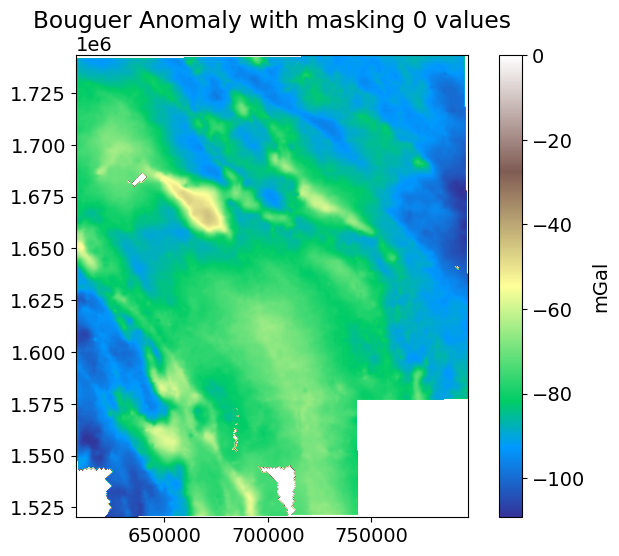

In [92]:
plt.figure(figsize=(8, 6))
plt.imshow(ba_filled, cmap="terrain", extent=(x.min(), x.max(), y.min(), y.max()))
plt.title(f"Bouguer Anomaly with masking 0 values")
plt.colorbar(label="mGal")
plt.show()

In [93]:
U, S, VT = svd(ba_filled, full_matrices=False)

In [94]:
print("Singular values Max & Min:", S.max(), S.min())

Singular values Max & Min: 31469.636429298924 0.05825371035855013


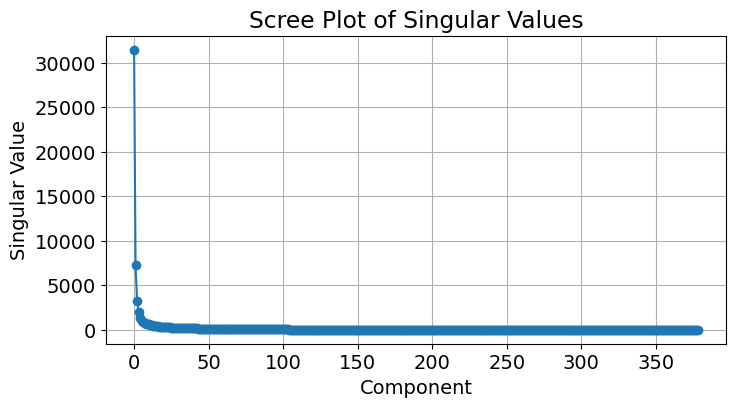

In [95]:
plt.figure(figsize=(8, 4))
plt.plot(S, marker='o')
plt.title("Scree Plot of Singular Values")
plt.xlabel("Component")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()

In [108]:
mode_indices = [0, 2, 4]
ba_selected = sum(S[i] * np.outer(U[:, i], VT[i, :]) for i in mode_indices)

In [109]:
ba_selected = np.ma.array(ba_selected, mask=ba.mask)

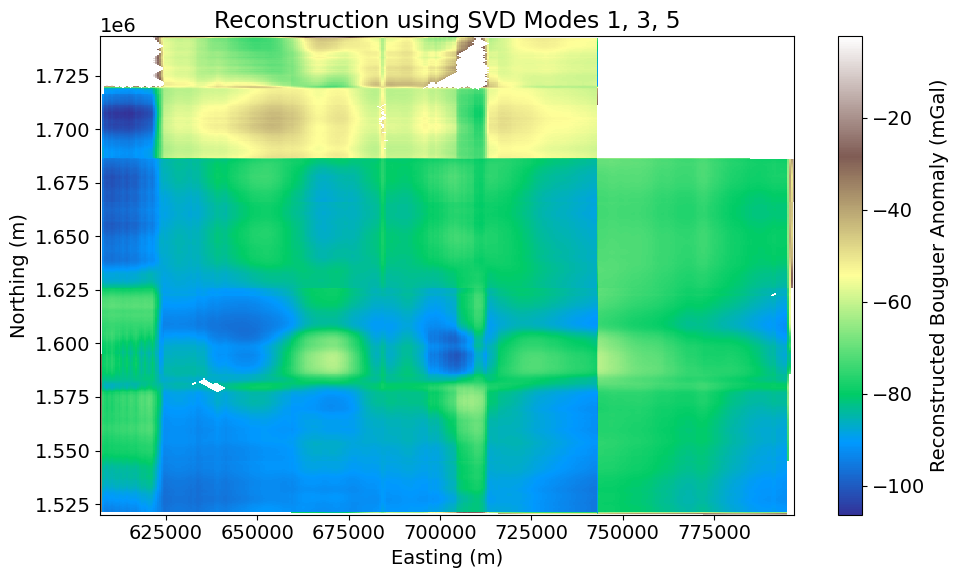

In [115]:
# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(xx, yy, ba_selected, cmap="terrain", shading="auto")
plt.colorbar(label="Reconstructed Bouguer Anomaly (mGal)")
plt.title("Reconstruction using SVD Modes 1, 3, 5")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [103]:
anomaly_map = np.abs(ba_filled - ba_reconstructed)

In [104]:
anomaly_map = np.ma.array(anomaly_map, mask=ba.mask).copy()

In [106]:
residual_svd = ba_filled - ba_reconstructed

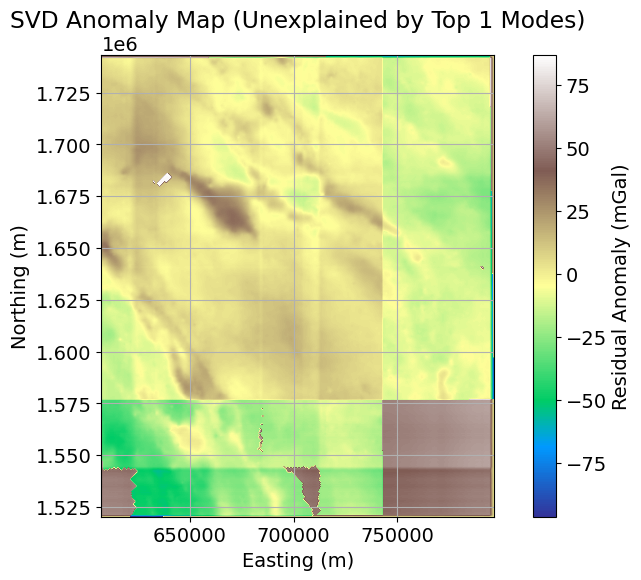

In [107]:
# 7. Plot anomaly strength map
plt.figure(figsize=(10, 6))
plt.imshow(residual_svd, cmap='terrain', extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar(label="Residual Anomaly (mGal)")
plt.title(f"SVD Anomaly Map (Unexplained by Top {k} Modes)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True)
plt.show()